# Preprocessing Data

In [45]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
from pathlib import Path
import h5py
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

class MusicPreprocessor:
    """
    Advanced preprocessing pipeline for CycleGAN music genre transformation
    """
    
    def __init__(self, 
                 sample_rate: int = 22050,
                 segment_duration: float = 10.0,
                 overlap_ratio: float = 0.5,
                 n_fft: int = 2048,
                 hop_length: int = 512,
                 n_mels: int = 128,
                 fmin: float = 0.0,
                 fmax: float = 8000.0,
                 normalize_audio: bool = True,
                 log_scale: bool = True,
                 spectrogram_size: Tuple[int, int] = (128, 128)):
        
        self.sample_rate = sample_rate
        self.segment_duration = segment_duration
        self.overlap_ratio = overlap_ratio
        self.segment_samples = int(segment_duration * sample_rate)
        self.hop_samples = int(self.segment_samples * (1 - overlap_ratio))
        
        # Spectrogram parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        self.normalize_audio = normalize_audio
        self.log_scale = log_scale
        self.spectrogram_size = spectrogram_size
        
        # Statistics for normalization
        self.global_mean = None
        self.global_std = None
        
    def load_and_preprocess_audio(self, file_path: str) -> np.ndarray:
        """
        Load and preprocess a single audio file
        """
        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=self.sample_rate, mono=True)
            
            # Remove silence from beginning and end
            audio = self._trim_silence(audio)
            
            # Normalize audio
            if self.normalize_audio:
                audio = self._normalize_audio(audio)
                
            return audio
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None
    
    def _trim_silence(self, audio: np.ndarray, top_db: int = 30) -> np.ndarray:
        """
        Remove silence from beginning and end of audio
        """
        audio_trimmed, _ = librosa.effects.trim(audio, top_db=top_db)
        return audio_trimmed
    
    def _normalize_audio(self, audio: np.ndarray, method: str = 'peak') -> np.ndarray:
        """
        Normalize audio signal
        """
        if method == 'peak':
            # Peak normalization
            peak = np.max(np.abs(audio))
            if peak > 0:
                audio = audio / peak
        elif method == 'rms':
            # RMS normalization
            rms = np.sqrt(np.mean(audio**2))
            if rms > 0:
                audio = audio / rms
                # Prevent clipping
                peak = np.max(np.abs(audio))
                if peak > 1.0:
                    audio = audio / peak
        
        return audio
    
    def segment_audio(self, audio: np.ndarray) -> List[np.ndarray]:
        """
        Split audio into overlapping segments
        """
        segments = []
        
        if len(audio) < self.segment_samples:
            # Pad short audio files
            padding = self.segment_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        
        # Create overlapping segments
        for start in range(0, len(audio) - self.segment_samples + 1, self.hop_samples):
            segment = audio[start:start + self.segment_samples]
            segments.append(segment)
        
        return segments
    
    def audio_to_melspectrogram(self, audio: np.ndarray) -> np.ndarray:
        """
        Convert audio segment to mel spectrogram
        """
        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax,
            power=2.0
        )
        
        # Apply logarithmic scaling
        if self.log_scale:
            mel_spec = np.log1p(mel_spec)  
        
        return mel_spec
    
    def resize_spectrogram(self, spectrogram: np.ndarray) -> np.ndarray:
        """
        Resize spectrogram to fixed dimensions
        """
        from scipy.ndimage import zoom
        
        current_shape = spectrogram.shape
        zoom_factors = (
            self.spectrogram_size[0] / current_shape[0],
            self.spectrogram_size[1] / current_shape[1]
        )
        
        resized = zoom(spectrogram, zoom_factors, order=1)
        return resized
    
    def compute_dataset_statistics(self, spectrograms: List[np.ndarray]) -> Tuple[float, float]:
        """
        Compute global mean and standard deviation for normalization
        """
        all_values = np.concatenate([spec.flatten() for spec in spectrograms])
        mean = np.mean(all_values)
        std = np.std(all_values)
        
        self.global_mean = mean
        self.global_std = std
        
        return mean, std
    
    def normalize_spectrogram(self, spectrogram: np.ndarray) -> np.ndarray:
        """
        Normalize spectrogram using global statistics
        """
        if self.global_mean is None or self.global_std is None:
            raise ValueError("Global statistics not computed. Call compute_dataset_statistics first.")
        
        normalized = (spectrogram - self.global_mean) / (self.global_std + 1e-8)
        return normalized
    
    def process_genre_directory(self, genre_dir: str, genre_name: str) -> Tuple[np.ndarray, List[str]]:
        """
        Process all audio files in a genre directory
        """
        audio_files = []
        for ext in ['*.wav', '*.mp3', '*.flac', '*.m4a']:
            audio_files.extend(Path(genre_dir).glob(ext))
        
        all_spectrograms = []
        file_info = []
        
        print(f"Processing {len(audio_files)} files for genre: {genre_name}")
        
        for i, file_path in enumerate(audio_files):
            print(f"Processing {i+1}/{len(audio_files)}: {file_path.name}")
            
            # Load and preprocess audio
            audio = self.load_and_preprocess_audio(str(file_path))
            if audio is None:
                continue
            
            # Segment audio
            segments = self.segment_audio(audio)
            
            # Convert each segment to spectrogram
            for j, segment in enumerate(segments):
                mel_spec = self.audio_to_melspectrogram(segment)
                mel_spec_resized = self.resize_spectrogram(mel_spec)
                
                all_spectrograms.append(mel_spec_resized)
                file_info.append(f"{file_path.stem}_segment_{j}")
        
        return np.array(all_spectrograms), file_info
    
    def save_processed_data(self, spectrograms: np.ndarray, file_info: List[str], 
                          output_path: str, genre_name: str):
        """
        Save processed spectrograms to HDF5 file
        """
        with h5py.File(output_path, 'w') as f:
            # Save spectrograms
            f.create_dataset(f'{genre_name}_spectrograms', data=spectrograms, 
                           compression='gzip', compression_opts=9)
            
            # Save file information
            f.create_dataset(f'{genre_name}_file_info', 
                           data=[s.encode('utf-8') for s in file_info])
            
            # Save preprocessing parameters
            params = f.create_group(f'{genre_name}_params')
            params.attrs['sample_rate'] = self.sample_rate
            params.attrs['n_fft'] = self.n_fft
            params.attrs['hop_length'] = self.hop_length
            params.attrs['n_mels'] = self.n_mels
            params.attrs['segment_duration'] = self.segment_duration
            params.attrs['spectrogram_size'] = self.spectrogram_size
            
            if self.global_mean is not None:
                params.attrs['global_mean'] = self.global_mean
                params.attrs['global_std'] = self.global_std
    
    def load_processed_data(self, file_path: str, genre_name: str) -> Tuple[np.ndarray, List[str]]:
        """
        Load processed data from HDF5 file
        """
        with h5py.File(file_path, 'r') as f:
            spectrograms = f[f'{genre_name}_spectrograms'][:]
            file_info = [s.decode('utf-8') for s in f[f'{genre_name}_file_info'][:]]
            
            # Load normalization parameters
            if f'{genre_name}_params' in f:
                params = f[f'{genre_name}_params']
                if 'global_mean' in params.attrs:
                    self.global_mean = params.attrs['global_mean']
                    self.global_std = params.attrs['global_std']
        
        return spectrograms, file_info



In [3]:

"""
Example usage of the preprocessing pipeline
"""
# Initialize preprocessor
preprocessor = MusicPreprocessor(
    sample_rate=22050,
    segment_duration=10.0,
    overlap_ratio=0.5,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
    spectrogram_size=(128, 128)
)

# Define paths
genre_a_dir = "D:/uni/DeepLearning/Prog/archive/Data/genres_original/rock"
genre_b_dir = "D:/uni/DeepLearning/Prog/archive/Data/genres_original/classical"
output_file = "processed_music_data.h5"

# Process both genres
print("Processing Genre A...")
spectrograms_a, info_a = preprocessor.process_genre_directory(genre_a_dir, "genre_a")

print("Processing Genre B...")
spectrograms_b, info_b = preprocessor.process_genre_directory(genre_b_dir, "genre_b")

# Compute global statistics for normalization
print("Computing global statistics...")
all_spectrograms = np.concatenate([spectrograms_a, spectrograms_b])
preprocessor.compute_dataset_statistics(all_spectrograms)

# Normalize spectrograms
print("Normalizing spectrograms...")
spectrograms_a_norm = np.array([preprocessor.normalize_spectrogram(spec) 
                                for spec in spectrograms_a])
spectrograms_b_norm = np.array([preprocessor.normalize_spectrogram(spec) 
                                for spec in spectrograms_b])

# Save processed data
print("Saving processed data...")
preprocessor.save_processed_data(spectrograms_a_norm, info_a, output_file, "genre_a")

# For genre B, append to existing file
with h5py.File(output_file, 'a') as f:
    f.create_dataset('genre_b_spectrograms', data=spectrograms_b_norm, 
                    compression='gzip', compression_opts=9)
    f.create_dataset('genre_b_file_info', 
                    data=[s.encode('utf-8') for s in info_b])
    
    params = f.create_group('genre_b_params')
    params.attrs['sample_rate'] = preprocessor.sample_rate
    params.attrs['global_mean'] = preprocessor.global_mean
    params.attrs['global_std'] = preprocessor.global_std

print(f"Preprocessing complete!")
print(f"Genre A: {len(spectrograms_a_norm)} spectrograms")
print(f"Genre B: {len(spectrograms_b_norm)} spectrograms")
print(f"Spectrogram shape: {spectrograms_a_norm[0].shape}")
print(f"Data saved to: {output_file}")



Processing Genre A...
Processing 100 files for genre: genre_a
Processing 1/100: rock.00000.wav
Processing 2/100: rock.00001.wav
Processing 3/100: rock.00002.wav
Processing 4/100: rock.00003.wav
Processing 5/100: rock.00004.wav
Processing 6/100: rock.00005.wav
Processing 7/100: rock.00006.wav
Processing 8/100: rock.00007.wav
Processing 9/100: rock.00008.wav
Processing 10/100: rock.00009.wav
Processing 11/100: rock.00010.wav
Processing 12/100: rock.00011.wav
Processing 13/100: rock.00012.wav
Processing 14/100: rock.00013.wav
Processing 15/100: rock.00014.wav
Processing 16/100: rock.00015.wav
Processing 17/100: rock.00016.wav
Processing 18/100: rock.00017.wav
Processing 19/100: rock.00018.wav
Processing 20/100: rock.00019.wav
Processing 21/100: rock.00020.wav
Processing 22/100: rock.00021.wav
Processing 23/100: rock.00022.wav
Processing 24/100: rock.00023.wav
Processing 25/100: rock.00024.wav
Processing 26/100: rock.00025.wav
Processing 27/100: rock.00026.wav
Processing 28/100: rock.00027

In [58]:
"""
Example usage of the preprocessing pipeline
"""
# Initialize preprocessor
preprocessor = MusicPreprocessor(
    sample_rate=22050,
    segment_duration=10.0,
    overlap_ratio=0.5,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
    spectrogram_size=(128, 512)
)

# Define paths
genre_a_dir = "D:/uni/DeepLearning/Prog/archive/Data/genres_original/rock"
genre_b_dir = "D:/uni/DeepLearning/Prog/archive/Data/genres_original/classical"
output_file = "processed_music_data_128x512.h5"

# Process both genres
print("Processing Genre A...")
spectrograms_a, info_a = preprocessor.process_genre_directory(genre_a_dir, "genre_a")

print("Processing Genre B...")
spectrograms_b, info_b = preprocessor.process_genre_directory(genre_b_dir, "genre_b")

# Compute global statistics for normalization
print("Computing global statistics...")
all_spectrograms = np.concatenate([spectrograms_a, spectrograms_b])
preprocessor.compute_dataset_statistics(all_spectrograms)

# Normalize spectrograms
print("Normalizing spectrograms...")
spectrograms_a_norm = np.array([preprocessor.normalize_spectrogram(spec) 
                                for spec in spectrograms_a])
spectrograms_b_norm = np.array([preprocessor.normalize_spectrogram(spec) 
                                for spec in spectrograms_b])

# Save processed data
print("Saving processed data...")
preprocessor.save_processed_data(spectrograms_a_norm, info_a, output_file, "genre_a")

# For genre B, append to existing file
with h5py.File(output_file, 'a') as f:
    f.create_dataset('genre_b_spectrograms', data=spectrograms_b_norm, 
                    compression='gzip', compression_opts=9)
    f.create_dataset('genre_b_file_info', 
                    data=[s.encode('utf-8') for s in info_b])
    
    params = f.create_group('genre_b_params')
    params.attrs['sample_rate'] = preprocessor.sample_rate
    params.attrs['global_mean'] = preprocessor.global_mean
    params.attrs['global_std'] = preprocessor.global_std

print(f"Preprocessing complete!")
print(f"Genre A: {len(spectrograms_a_norm)} spectrograms")
print(f"Genre B: {len(spectrograms_b_norm)} spectrograms")
print(f"Spectrogram shape: {spectrograms_a_norm[0].shape}")
print(f"Data saved to: {output_file}")

Processing Genre A...
Processing 100 files for genre: genre_a
Processing 1/100: rock.00000.wav
Processing 2/100: rock.00001.wav
Processing 3/100: rock.00002.wav
Processing 4/100: rock.00003.wav
Processing 5/100: rock.00004.wav
Processing 6/100: rock.00005.wav
Processing 7/100: rock.00006.wav
Processing 8/100: rock.00007.wav
Processing 9/100: rock.00008.wav
Processing 10/100: rock.00009.wav
Processing 11/100: rock.00010.wav
Processing 12/100: rock.00011.wav
Processing 13/100: rock.00012.wav
Processing 14/100: rock.00013.wav
Processing 15/100: rock.00014.wav
Processing 16/100: rock.00015.wav
Processing 17/100: rock.00016.wav
Processing 18/100: rock.00017.wav
Processing 19/100: rock.00018.wav
Processing 20/100: rock.00019.wav
Processing 21/100: rock.00020.wav
Processing 22/100: rock.00021.wav
Processing 23/100: rock.00022.wav
Processing 24/100: rock.00023.wav
Processing 25/100: rock.00024.wav
Processing 26/100: rock.00025.wav
Processing 27/100: rock.00026.wav
Processing 28/100: rock.00027

# inizializza utilizzo gpu

In [49]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load and split

In [4]:
import numpy as np
import h5py
import tensorflow as tf
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, List, Optional
import matplotlib.pyplot as plt
import random
from pathlib import Path

class MusicDataLoader:
    """
    TensorFlow data loader class for CycleGAN music genre transformation
    """
    
    def __init__(self, data_file: str, batch_size: int = 32, 
                 train_split: float = 0.8, val_split: float = 0.1,
                 buffer_size: int = 1000, prefetch_size: int = tf.data.AUTOTUNE,
                 seed: int = 42):
        
        self.data_file = data_file
        self.batch_size = batch_size
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = 1.0 - train_split - val_split
        self.buffer_size = buffer_size
        self.prefetch_size = prefetch_size
        self.seed = seed
        
        # Set seeds for reproducibility
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        # Load data
        self.genre_a_data, self.genre_b_data = self._load_data()
        self.preprocessing_params = self._load_preprocessing_params()
        
        # Split data
        self.splits = self._create_splits()
    
    def _load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Load processed spectrograms from HDF5 file
        """
        print(f"Loading data from {self.data_file}...")
        
        with h5py.File(self.data_file, 'r') as f:
            # Load spectrograms for both genres
            genre_a_spectrograms = f['genre_a_spectrograms'][:]
            genre_b_spectrograms = f['genre_b_spectrograms'][:]
            
            print(f"Loaded Genre A: {genre_a_spectrograms.shape}")
            print(f"Loaded Genre B: {genre_b_spectrograms.shape}")
        
        return genre_a_spectrograms, genre_b_spectrograms
    
    def _load_preprocessing_params(self) -> Dict:
        """
        Load preprocessing parameters for reference
        """
        params = {}
        with h5py.File(self.data_file, 'r') as f:
            if 'genre_a_params' in f:
                genre_a_params = f['genre_a_params']
                for key in genre_a_params.attrs:
                    params[key] = genre_a_params.attrs[key]
        
        return params
    
    def _create_splits(self) -> Dict[str, Dict[str, np.ndarray]]:
        """
        Create train/validation/test splits for both genres
        """
        print("Creating train/validation/test splits...")
        
        splits = {'train': {}, 'val': {}, 'test': {}}
        
        for genre_name, spectrograms in [('A', self.genre_a_data), ('B', self.genre_b_data)]:
            # First split: train + val vs test
            train_val, test = train_test_split(
                spectrograms, 
                test_size=self.test_split, 
                random_state=self.seed,
                shuffle=True
            )
            
            # Second split: train vs val
            if self.val_split > 0:
                val_size = self.val_split / (self.train_split + self.val_split)
                train, val = train_test_split(
                    train_val,
                    test_size=val_size,
                    random_state=self.seed,
                    shuffle=True
                )
            else:
                train = train_val
                val = np.array([]).reshape(0, *train_val.shape[1:])
            
            splits['train'][genre_name] = train
            splits['val'][genre_name] = val
            splits['test'][genre_name] = test
            
            print(f"Genre {genre_name} - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
        
        return splits
    
    def _preprocess_spectrogram(self, spectrogram):
        """
        Preprocess spectrogram for training
        """
        # Add channel dimension if not present (H, W) -> (H, W, 1)
        if len(spectrogram.shape) == 2:
            spectrogram = tf.expand_dims(spectrogram, axis=-1)
        
        # Ensure float32 type
        spectrogram = tf.cast(spectrogram, tf.float32)
        
        return spectrogram
    
    def create_tf_dataset(self, spectrograms: np.ndarray, shuffle: bool = True, 
                         repeat: bool = False) -> tf.data.Dataset:
        """
        Create a TensorFlow dataset from spectrograms
        """
        # Create dataset from numpy array
        dataset = tf.data.Dataset.from_tensor_slices(spectrograms)
        
        # Preprocess spectrograms
        dataset = dataset.map(
            self._preprocess_spectrogram,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        # Shuffle if requested
        if shuffle:
            dataset = dataset.shuffle(self.buffer_size, seed=self.seed)
        
        # Repeat if requested (for infinite datasets)
        if repeat:
            dataset = dataset.repeat()
        
        # Batch the data
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        
        # Prefetch for performance
        dataset = dataset.prefetch(self.prefetch_size)
        
        return dataset
    
    def get_datasets(self, mode: str = 'unpaired') -> Dict[str, tf.data.Dataset]:
        """
        Get TensorFlow datasets for training
        
        Args:
            mode: 'unpaired' for separate A and B datasets, 'paired' for combined dataset
        """
        datasets = {}
        
        if mode == 'unpaired':
            # Separate datasets for each domain (standard CycleGAN approach)
            for split in ['train', 'val', 'test']:
                if len(self.splits[split]['A']) == 0:
                    continue
                    
                shuffle = (split == 'train')
                
                datasets[f'{split}_A'] = self.create_tf_dataset(
                    self.splits[split]['A'],
                    shuffle=shuffle,
                    repeat=False
                )
                
                datasets[f'{split}_B'] = self.create_tf_dataset(
                    self.splits[split]['B'],
                    shuffle=shuffle,
                    repeat=False
                )
        
        elif mode == 'paired':
            # Paired datasets (both domains in same batch)
            for split in ['train', 'val', 'test']:
                if len(self.splits[split]['A']) == 0:
                    continue
                
                # Ensure both domains have same length
                min_len = min(len(self.splits[split]['A']), len(self.splits[split]['B']))
                data_a = self.splits[split]['A'][:min_len]
                data_b = self.splits[split]['B'][:min_len]
                
                # Create paired dataset
                dataset_a = tf.data.Dataset.from_tensor_slices(data_a)
                dataset_b = tf.data.Dataset.from_tensor_slices(data_b)
                
                # Combine datasets
                dataset = tf.data.Dataset.zip((dataset_a, dataset_b))
                
                # Preprocess both spectrograms
                dataset = dataset.map(
                    lambda a, b: {
                        'A': self._preprocess_spectrogram(a),
                        'B': self._preprocess_spectrogram(b)
                    },
                    num_parallel_calls=tf.data.AUTOTUNE
                )
                
                # Shuffle if training
                if split == 'train':
                    dataset = dataset.shuffle(self.buffer_size, seed=self.seed)
                
                # Batch and prefetch
                dataset = dataset.batch(self.batch_size, drop_remainder=True)
                dataset = dataset.prefetch(self.prefetch_size)
                
                datasets[split] = dataset
        
        return datasets
    
    def get_infinite_dataset(self, genre: str, split: str = 'train') -> tf.data.Dataset:
        """
        Get an infinite dataset that cycles through data indefinitely
        Useful for CycleGAN training where you need different cycling frequencies
        """
        return self.create_tf_dataset(
            self.splits[split][genre],
            shuffle=True,
            repeat=True  # This makes it infinite
        )
    
    def get_train_datasets_infinite(self) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
        """
        Get infinite training datasets for both genres
        Standard setup for CycleGAN training
        """
        train_A = self.get_infinite_dataset('A', 'train')
        train_B = self.get_infinite_dataset('B', 'train')
        
        return train_A, train_B
    
    def visualize_samples(self, num_samples: int = 4, split: str = 'train'):
        """
        Visualize sample spectrograms from both genres
        """
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
        # Sample from each genre
        for i in range(num_samples):
            # Genre A
            idx_a = np.random.randint(0, len(self.splits[split]['A']))
            spec_a = self.splits[split]['A'][idx_a]
            axes[0, i].imshow(spec_a, aspect='auto', origin='lower', cmap='viridis')
            axes[0, i].set_title(f'Genre A - Sample {i+1}')
            axes[0, i].axis('off')
            
            # Genre B
            idx_b = np.random.randint(0, len(self.splits[split]['B']))
            spec_b = self.splits[split]['B'][idx_b]
            axes[1, i].imshow(spec_b, aspect='auto', origin='lower', cmap='viridis')
            axes[1, i].set_title(f'Genre B - Sample {i+1}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def get_data_info(self) -> Dict:
        """
        Get information about the loaded data
        """
        info = {
            'preprocessing_params': self.preprocessing_params,
            'data_shapes': {
                'genre_A': self.genre_a_data.shape,
                'genre_B': self.genre_b_data.shape
            },
            'split_sizes': {},
            'batch_size': self.batch_size,
            'total_batches': {}
        }
        
        for split in ['train', 'val', 'test']:
            info['split_sizes'][split] = {
                'A': len(self.splits[split]['A']),
                'B': len(self.splits[split]['B'])
            }
            
            info['total_batches'][split] = {
                'A': len(self.splits[split]['A']) // self.batch_size,
                'B': len(self.splits[split]['B']) // self.batch_size
            }
        
        return info
    
    def save_splits(self, output_file: str):
        """
        Save the train/val/test splits for reproducibility
        """
        with h5py.File(output_file, 'w') as f:
            for split in ['train', 'val', 'test']:
                split_group = f.create_group(split)
                split_group.create_dataset('A', data=self.splits[split]['A'], 
                                         compression='gzip', compression_opts=9)
                split_group.create_dataset('B', data=self.splits[split]['B'], 
                                         compression='gzip', compression_opts=9)
            
            # Save metadata
            f.attrs['batch_size'] = self.batch_size
            f.attrs['train_split'] = self.train_split
            f.attrs['val_split'] = self.val_split
            f.attrs['seed'] = self.seed
        
        print(f"Splits saved to {output_file}")



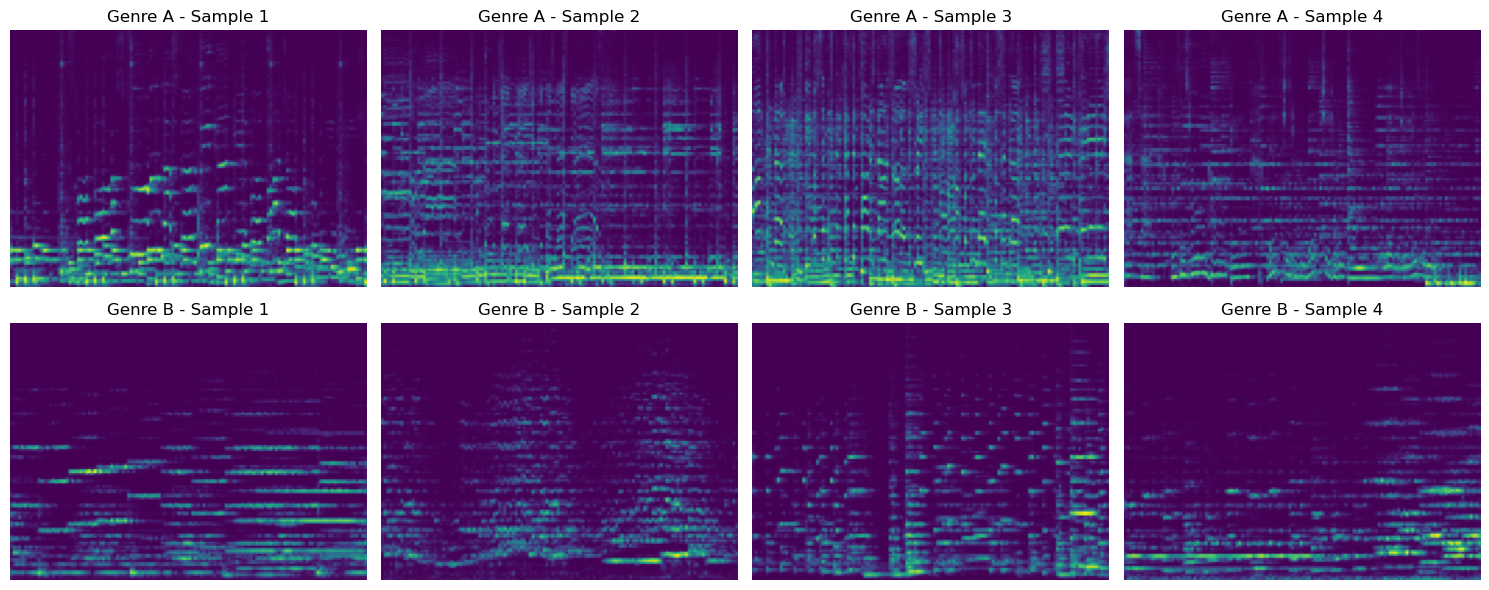

In [7]:
data_loader.visualize_samples()

# Spettrogramma to Audio Prova 1 griffin-lim

In [43]:
import os
import numpy as np
import librosa
import librosa.display
import soundfile as sf
import h5py
from scipy.ndimage import zoom
import warnings
from IPython.display import Audio, display
warnings.filterwarnings('ignore')

class MusicReconstructor:
    """
    Reconstructs audio from a processed mel spectrogram.
    This class is designed to reverse the steps of the MusicPreprocessor.
    """
    def __init__(self, processed_data_path: str):
        self.h5_path = processed_data_path
        self.params = {}
        self._load_params()
        
        # Calculate original spectrogram time dimension before resizing
        # This is crucial for reversing the resize step
        segment_samples = int(self.params['genre_a']['segment_duration'] * self.params['genre_a']['sample_rate'])
        self.original_time_steps = int(np.ceil(segment_samples / self.params['genre_a']['hop_length']))

    def _load_params(self):
        """Loads preprocessing parameters from the HDF5 file."""
        with h5py.File(self.h5_path, 'r') as f:
            for genre_key in ['genre_a_params', 'genre_b_params']:
                if genre_key in f:
                    #genre_name = genre_key.split('_')[0]
                    genre_name = '_'.join(genre_key.split('_', 2)[:2])
                    print(genre_name)
                    self.params[genre_name] = dict(f[genre_key].attrs)
                    print(self.params[genre_name])

    def _denormalize_spectrogram(self, norm_spec: np.ndarray, genre_name: str) -> np.ndarray:
        """Reverses z-score normalization."""
        mean = self.params[genre_name]['global_mean']
        std = self.params[genre_name]['global_std']
        return (norm_spec * std) + mean

    def _unresize_spectrogram(self, resized_spec: np.ndarray, genre_name: str) -> np.ndarray:
        """
        Reverses the resizing operation.
        NOTE: This is an approximation and the main source of quality loss.
        """
        original_n_mels = self.params[genre_name]['n_mels']
        target_shape = (original_n_mels, self.original_time_steps)
        
        # Calculate zoom factors to scale it back up
        zoom_factors = (
            target_shape[0] / resized_spec.shape[0],
            target_shape[1] / resized_spec.shape[1]
        )
        
        # Use scipy.ndimage.zoom, same as in the preprocessor
        unresized_spec = zoom(resized_spec, zoom_factors, order=1)
        return unresized_spec

    def _inverse_log_scale(self, log_spec: np.ndarray) -> np.ndarray:
        """Reverses the log1p operation."""
        return np.expm1(log_spec)

    def _melspectrogram_to_audio(self, mel_spec: np.ndarray, genre_name: str) -> np.ndarray:
        """Converts a mel spectrogram back to an audio waveform."""
        params = self.params[genre_name]
        
        # Use librosa's inversion function
        # It uses an iterative algorithm (Griffin-Lim) to estimate the phase
        audio = librosa.feature.inverse.mel_to_audio(
            mel_spec,
            sr=params['sample_rate'],
            n_fft=params['n_fft'],
            hop_length=params['hop_length'],
            n_iter=32 # More iterations can improve quality but are slower
        )
        return audio

    def reconstruct_and_save(self, 
                             input_spectrogram: np.ndarray, 
                             genre_name: str, 
                             output_path: str):
        """
        Performs the full reconstruction pipeline for a single spectrogram
        and saves it as a WAV file.
        """
        if genre_name not in self.params:
            raise ValueError(f"Parameters for genre '{genre_name}' not found in HDF5 file.")
        
        print("Step 1: Denormalizing spectrogram...")
        denorm_spec = self._denormalize_spectrogram(input_spectrogram, genre_name)
        
        print("Step 2: Un-resizing spectrogram...")
        unresized_spec = self._unresize_spectrogram(denorm_spec, genre_name)
        
        print("Step 3: Reversing log scaling...")
        linear_spec = self._inverse_log_scale(unresized_spec)
        
        # Ensure no negative values after expm1 due to floating point inaccuracies
        linear_spec[linear_spec < 0] = 0
        
        print("Step 4: Inverting mel spectrogram to audio (Griffin-Lim)...")
        audio_waveform = self._melspectrogram_to_audio(linear_spec, genre_name)
        
        print(f"Step 5: Saving audio to {output_path}...")
        sf.write(output_path, audio_waveform, self.params[genre_name]['sample_rate'])
        print("Reconstruction complete!")

    def reconstruct_and_show(self, 
                            input_spectrogram: np.ndarray, 
                            genre_name: str, 
                            output_path: str):
        """
        Performs the full reconstruction pipeline for a single spectrogram
        and saves it as a WAV file.
        """
        if genre_name not in self.params:
            raise ValueError(f"Parameters for genre '{genre_name}' not found in HDF5 file.")
        
        print("Step 1: Denormalizing spectrogram...")
        denorm_spec = self._denormalize_spectrogram(input_spectrogram, genre_name)
        
        print("Step 2: Un-resizing spectrogram...")
        unresized_spec = self._unresize_spectrogram(denorm_spec, genre_name)
        
        print("Step 3: Reversing log scaling...")
        linear_spec = self._inverse_log_scale(unresized_spec)
        
        # Ensure no negative values after expm1 due to floating point inaccuracies
        linear_spec[linear_spec < 0] = 0
        
        print("Step 4: Inverting mel spectrogram to audio (Griffin-Lim)...")
        audio_waveform = self._melspectrogram_to_audio(linear_spec, genre_name)
        
        display(Audio(audio_waveform, rate=22050))




In [59]:
# The path to the HDF5 file you created
h5_file_path = "processed_music_data_128x512.h5"

# The genre you want to reconstruct from ('genre_a' or 'genre_b')
# This corresponds to 'rock' in your example.
target_genre = 'genre_a' 

# The index of the spectrogram you want to convert. Let's take the first one.
spectrogram_index = 10

# Path for the output WAV file
output_wav_path = "reconstructed_audio_sample.wav"

# 1. Initialize the reconstructor
# This will automatically load all the necessary parameters from the H5 file.
try:
    reconstructor = MusicReconstructor(h5_file_path)
except FileNotFoundError:
    print(f"Error: The file '{h5_file_path}' was not found. Please ensure it's in the correct directory.")
    exit()

# 2. Load the specific spectrogram from the HDF5 file
with h5py.File(h5_file_path, 'r') as f:
    spectrograms_dataset_key = f'{target_genre}_spectrograms'
    if spectrograms_dataset_key not in f:
        print(f"Error: Dataset '{spectrograms_dataset_key}' not found in the H5 file.")
        exit()
        
    # Load just one spectrogram
    the_spectrogram_to_reconstruct = f[spectrograms_dataset_key][spectrogram_index]
    print(f"Loaded spectrogram with shape: {the_spectrogram_to_reconstruct.shape}")


# 3. Run the reconstruction and save the audio
reconstructor.reconstruct_and_show(
    input_spectrogram=the_spectrogram_to_reconstruct,
    genre_name=target_genre,
    output_path=output_wav_path
)

genre_a
{'global_mean': 0.61482424, 'global_std': 1.0337923, 'hop_length': 512, 'n_fft': 2048, 'n_mels': 128, 'sample_rate': 22050, 'segment_duration': 10.0, 'spectrogram_size': array([128, 512])}
genre_b
{'global_mean': 0.61482424, 'global_std': 1.0337923, 'sample_rate': 22050}
Loaded spectrogram with shape: (128, 512)
Step 1: Denormalizing spectrogram...
Step 2: Un-resizing spectrogram...
Step 3: Reversing log scaling...
Step 4: Inverting mel spectrogram to audio (Griffin-Lim)...


# modello generatore e discriminatore

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_addons.layers import InstanceNormalization

def generator_with_dilated_cnn(input_shape=(128, 128, 1), name="Generator"):
    """Builds a generator with a dilated convolution bottleneck."""
    inputs = layers.Input(shape=input_shape)

    # --- Downsampling Path (Encoder) ---
    down_stack = [
        (64, 4, False),   # (filters, kernel_size, apply_instancenorm)
        (128, 4, True),
        (256, 4, True),
    ]

    x = inputs
    skips = []
    for filters, size, apply_norm in down_stack:
        x = layers.Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
        if apply_norm:
            x = InstanceNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        skips.append(x)

    # --- Bottleneck with Dilated Convolutions ---
    # This replaces the standard ResNet blocks
    dilation_rates = [1, 2, 4, 8, 4, 2, 1] # A symmetric pattern of dilations original for 32x32
    #dilation_rates = [1, 2, 4, 2, 1] #reduced for 16x16 maps
    for rate in dilation_rates:
        # We use a residual connection around the dilated convolution
        shortcut = x
        f = layers.Conv2D(256, 3, padding='same', dilation_rate=rate,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
        f = InstanceNormalization()(f)
        f = layers.LeakyReLU(0.2)(f)
        x = layers.Add()([shortcut, f])


    # --- Upsampling Path (Decoder) with Skip Connections ---
    skips = reversed(skips[:-1])
    up_stack = [
        (128, 4, True),
        (64, 4, True),
    ]

    for (filters, size, apply_dropout), skip in zip(up_stack, skips):
        x = layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
        x = InstanceNormalization()(x)
        if apply_dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.ReLU()(x)
        # Concatenate skip connection (U-Net style)
        x = layers.Concatenate()([x, skip])

    # Final Layer
    last = layers.Conv2DTranspose(input_shape[-1], 4, strides=2, padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                  activation='tanh') # Output is normalized to [-1, 1]
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name=name)

# --- The Discriminator (PatchGAN) ---
def discriminator(input_shape=(128, 128, 1), name="Discriminator"):
    """Builds a PatchGAN discriminator."""
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=1, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Final patch output
    last = layers.Conv2D(1, 4, strides=1, padding='same',
                         kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)

    return tf.keras.Model(inputs=inputs, outputs=last, name=name)

# modello CycleGan

In [53]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import losses, optimizers
import matplotlib.pyplot as plt
class CycleGAN:
    def __init__(self, generator_AB, generator_BA, discriminator_A, discriminator_B, 
                 lambda_cycle=10.0, lambda_identity=0.5):
        """
        Initialize CycleGAN for music genre translation
        
        Args:
            generator_AB: Generator that translates from genre A to B
            generator_BA: Generator that translates from genre B to A
            discriminator_A: Discriminator for genre A
            discriminator_B: Discriminator for genre B
            lambda_cycle: Weight for cycle consistency loss
            lambda_identity: Weight for identity loss
        """
        self.gen_AB = generator_AB
        self.gen_BA = generator_BA
        self.disc_A = discriminator_A
        self.disc_B = discriminator_B
        
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
        # Optimizers
        self.gen_optimizer = optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.disc_optimizer = optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        
        # Loss tracking
        self.gen_loss_tracker = tf.keras.metrics.Mean(name='gen_loss')
        self.disc_loss_tracker = tf.keras.metrics.Mean(name='disc_loss')
        self.cycle_loss_tracker = tf.keras.metrics.Mean(name='cycle_loss')
        self.identity_loss_tracker = tf.keras.metrics.Mean(name='identity_loss')
        self.epoch_gen_losses = []
        self.epoch_disc_losses = []
        self.epoch_cycle_losses = []
        self.epoch_identity_losses = []
    
    def discriminator_loss(self, real_output, fake_output):
        """
        Calculate discriminator loss using least squares GAN loss
        """
        real_loss = tf.reduce_mean(tf.square(real_output - 1))
        fake_loss = tf.reduce_mean(tf.square(fake_output))
        return (real_loss + fake_loss) * 0.5
    
    def generator_loss(self, fake_output):
        """
        Calculate generator loss using least squares GAN loss
        """
        return tf.reduce_mean(tf.square(fake_output - 1))
    
    def cycle_consistency_loss(self, real_image, cycled_image):
        """
        Calculate cycle consistency loss (L1 loss)
        """
        return tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    def identity_loss(self, real_image, same_image):
        """
        Calculate identity loss (L1 loss)
        """
        return tf.reduce_mean(tf.abs(real_image - same_image))
    """
    @tf.function
    def train_step(self, real_A, real_B):
        """
        #Single training step for CycleGAN
    """
        print("partito training step")
        with tf.GradientTape(persistent=true) as tape:
            # Generate fake images
            fake_B = self.gen_AB(real_A, training=True)
            fake_A = self.gen_BA(real_B, training=True)
            print("generati fake")
            
            # Cycle the fake images back
            cycled_A = self.gen_BA(fake_B, training=True)
            cycled_B = self.gen_AB(fake_A, training=True)
            
            # Identity mapping (optional, helps preserve color/timbre)
            same_A = self.gen_BA(real_A, training=True)
            same_B = self.gen_AB(real_B, training=True)
            
            # Discriminator outputs
            disc_real_A = self.disc_A(real_A, training=True)
            disc_real_B = self.disc_B(real_B, training=True)
            disc_fake_A = self.disc_A(fake_A, training=True)
            disc_fake_B = self.disc_B(fake_B, training=True)
            
            # Generator losses
            gen_AB_loss = self.generator_loss(disc_fake_B)
            gen_BA_loss = self.generator_loss(disc_fake_A)
            
            # Cycle consistency losses
            cycle_loss_A = self.cycle_consistency_loss(real_A, cycled_A)
            cycle_loss_B = self.cycle_consistency_loss(real_B, cycled_B)
            cycle_loss = cycle_loss_A + cycle_loss_B
            
            # Identity losses
            identity_loss_A = self.identity_loss(real_A, same_A)
            identity_loss_B = self.identity_loss(real_B, same_B)
            identity_loss = identity_loss_A + identity_loss_B
            
            # Total generator loss
            total_gen_loss = (gen_AB_loss + gen_BA_loss + 
                            self.lambda_cycle * cycle_loss + 
                            self.lambda_identity * identity_loss)
            
            # Discriminator losses
            disc_A_loss = self.discriminator_loss(disc_real_A, disc_fake_A)
            disc_B_loss = self.discriminator_loss(disc_real_B, disc_fake_B)
            total_disc_loss = disc_A_loss + disc_B_loss
        
        # Calculate gradients
        gen_gradients = tape.gradient(total_gen_loss, 
                                    self.gen_AB.trainable_variables + 
                                    self.gen_BA.trainable_variables)
        
        disc_gradients = tape.gradient(total_disc_loss,
                                     self.disc_A.trainable_variables + 
                                     self.disc_B.trainable_variables)
        
        # Apply gradients
        self.gen_optimizer.apply_gradients(zip(gen_gradients, 
                                             self.gen_AB.trainable_variables + 
                                             self.gen_BA.trainable_variables))
        
        self.disc_optimizer.apply_gradients(zip(disc_gradients,
                                              self.disc_A.trainable_variables + 
                                              self.disc_B.trainable_variables))
        
        # Update metrics
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.disc_loss_tracker.update_state(total_disc_loss)
        self.cycle_loss_tracker.update_state(cycle_loss)
        self.identity_loss_tracker.update_state(identity_loss)

        print("finito training step")
        
        return {
            'gen_loss': self.gen_loss_tracker.result(),
            'disc_loss': self.disc_loss_tracker.result(),
            'cycle_loss': self.cycle_loss_tracker.result(),
            'identity_loss': self.identity_loss_tracker.result()
        }
    """
    @tf.function
    def train_step(self, real_A, real_B):
        """
        Single training step for CycleGAN, using two separate tapes for memory efficiency.
        """
        # A persistent tape is not needed. We will use two separate tapes.
        
        # --- Train Discriminators ---
        with tf.GradientTape() as disc_tape:
            # Generate fake images. These are needed for the discriminator loss.
            fake_B = self.gen_AB(real_A, training=True)
            fake_A = self.gen_BA(real_B, training=True)
            
            # Discriminator outputs for real and fake images
            disc_real_A = self.disc_A(real_A, training=True)
            disc_real_B = self.disc_B(real_B, training=True)
            
            disc_fake_A = self.disc_A(fake_A, training=True)
            disc_fake_B = self.disc_B(fake_B, training=True)
            
            # Calculate Discriminator losses
            disc_A_loss = self.discriminator_loss(disc_real_A, disc_fake_A)
            disc_B_loss = self.discriminator_loss(disc_real_B, disc_fake_B)
            total_disc_loss = disc_A_loss + disc_B_loss

        # Calculate and apply discriminator gradients
        disc_vars = self.disc_A.trainable_variables + self.disc_B.trainable_variables
        disc_gradients = disc_tape.gradient(total_disc_loss, disc_vars)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, disc_vars))

        # --- Train Generators ---
        with tf.GradientTape() as gen_tape:
            # We need to re-run the forward passes within this new tape
            # for the generator gradient calculation.
            
            # Adversarial loss
            fake_B = self.gen_AB(real_A, training=True)
            fake_A = self.gen_BA(real_B, training=True)
            disc_fake_B = self.disc_B(fake_B, training=True)
            disc_fake_A = self.disc_A(fake_A, training=True)
            gen_AB_loss = self.generator_loss(disc_fake_B)
            gen_BA_loss = self.generator_loss(disc_fake_A)
            
            # Cycle consistency loss
            cycled_A = self.gen_BA(fake_B, training=True)
            cycled_B = self.gen_AB(fake_A, training=True)
            cycle_loss = self.cycle_consistency_loss(real_A, cycled_A) + \
                         self.cycle_consistency_loss(real_B, cycled_B)
            
            # Identity loss
            same_A = self.gen_BA(real_A, training=True)
            same_B = self.gen_AB(real_B, training=True)
            identity_loss = self.identity_loss(real_A, same_A) + \
                            self.identity_loss(real_B, same_B)
            
            # Total generator loss
            total_gen_loss = (gen_AB_loss + gen_BA_loss + 
                              self.lambda_cycle * cycle_loss + 
                              self.lambda_identity * identity_loss)

        # Calculate and apply generator gradients
        gen_vars = self.gen_AB.trainable_variables + self.gen_BA.trainable_variables
        gen_gradients = gen_tape.gradient(total_gen_loss, gen_vars)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, gen_vars))
        
        # Update metrics (using the already computed loss values)
        self.gen_loss_tracker.update_state(total_gen_loss)
        self.disc_loss_tracker.update_state(total_disc_loss)
        self.cycle_loss_tracker.update_state(cycle_loss)
        self.identity_loss_tracker.update_state(identity_loss)
        
        return {
            'gen_loss': self.gen_loss_tracker.result(),
            'disc_loss': self.disc_loss_tracker.result(),
            'cycle_loss': self.cycle_loss_tracker.result(),
            'identity_loss': self.identity_loss_tracker.result()
        }
    
    def train(self, dataset_A, dataset_B, epochs, steps_per_epoch, 
              checkpoint_dir=None, sample_dir=None):
        """
        Train the CycleGAN
        
        Args:
            dataset_A: tf.data.Dataset for genre A mel spectrograms
            dataset_B: tf.data.Dataset for genre B mel spectrograms
            epochs: Number of training epochs
            steps_per_epoch: Number of steps per epoch
            checkpoint_dir: Directory to save checkpoints
            sample_dir: Directory to save sample translations
        """
        # Setup checkpointing
        if checkpoint_dir:
            checkpoint = tf.train.Checkpoint(
                gen_AB=self.gen_AB,
                gen_BA=self.gen_BA,
                disc_A=self.disc_A,
                disc_B=self.disc_B,
                gen_optimizer=self.gen_optimizer,
                disc_optimizer=self.disc_optimizer
            )
            checkpoint_manager = tf.train.CheckpointManager(
                checkpoint, checkpoint_dir, max_to_keep=5
            )
        
        # Training loop
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            
            # Reset metrics
            self.gen_loss_tracker.reset_states()
            self.disc_loss_tracker.reset_states()
            self.cycle_loss_tracker.reset_states()
            self.identity_loss_tracker.reset_states()
            
            # Zip datasets for paired training
            paired_dataset = tf.data.Dataset.zip((dataset_A, dataset_B))
            
            for step, (real_A, real_B) in enumerate(paired_dataset.take(steps_per_epoch)):
                losses = self.train_step(real_A, real_B)
                
                # Print progress
                if step % 100 == 0:
                    print(f"Step {step}: Gen Loss: {losses['gen_loss']:.4f}, "
                          f"Disc Loss: {losses['disc_loss']:.4f}, "
                          f"Cycle Loss: {losses['cycle_loss']:.4f}")
            
            # Save checkpoint
            if checkpoint_dir and (epoch + 1) % 10 == 0:
                checkpoint_manager.save()
                print(f"Checkpoint saved at epoch {epoch + 1}")
            
            # Generate sample translations
            if sample_dir and (epoch + 1) % 5 == 0:
                self.generate_samples(dataset_A, dataset_B, epoch + 1, sample_dir)
            
            self.epoch_gen_losses.append(self.gen_loss_tracker.result().numpy())
            self.epoch_disc_losses.append(self.disc_loss_tracker.result().numpy())
            self.epoch_cycle_losses.append(self.cycle_loss_tracker.result().numpy())
            self.epoch_identity_losses.append(self.identity_loss_tracker.result().numpy())
    
    def generate_samples(self, dataset_A, dataset_B, epoch, save_dir):
        """
        Generate and save sample translations
        """
        # Take a few samples from each dataset
        sample_A = next(iter(dataset_A.take(1)))
        sample_B = next(iter(dataset_B.take(1)))
        
        # Generate translations
        fake_B = self.gen_AB(sample_A, training=False)
        fake_A = self.gen_BA(sample_B, training=False)
        
        # Cycle back
        cycled_A = self.gen_BA(fake_B, training=False)
        cycled_B = self.gen_AB(fake_A, training=False)
        
        # Plot and save
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # First row: A -> B -> A
        axes[0, 0].imshow(sample_A[0].numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 0].set_title('Real A')
        axes[0, 1].imshow(fake_B[0].numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 1].set_title('Fake B')
        axes[0, 2].imshow(cycled_A[0].numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 2].set_title('Cycled A')
        axes[0, 3].imshow((sample_A[0] - cycled_A[0]).numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[0, 3].set_title('Difference')
        
        # Second row: B -> A -> B
        axes[1, 0].imshow(sample_B[0].numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 0].set_title('Real B')
        axes[1, 1].imshow(fake_A[0].numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 1].set_title('Fake A')
        axes[1, 2].imshow(cycled_B[0].numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 2].set_title('Cycled B')
        axes[1, 3].imshow((sample_B[0] - cycled_B[0]).numpy().squeeze(), aspect='auto', cmap='viridis')
        axes[1, 3].set_title('Difference')
        
        plt.tight_layout()
        plt.savefig(f"{save_dir}/samples_epoch_{epoch}.png")
        plt.close()
    
    def plot_training_losses(self, save_path=None):
        """
        Plot training losses stored during training.

        Args:
            save_path: Optional file path to save the figure instead of showing it.
        """
        plt.figure(figsize=(12, 8))
        plt.plot(self.epoch_gen_losses, label='Generator Loss')
        plt.plot(self.epoch_disc_losses, label='Discriminator Loss')
        plt.plot(self.epoch_cycle_losses, label='Cycle Consistency Loss')
        plt.plot(self.epoch_identity_losses, label='Identity Loss')
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('CycleGAN Training Losses Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            print(f"Loss plot saved to: {save_path}")
        else:
            plt.show()


# Crea dataset

In [6]:
# Initialize data loader
data_loader = MusicDataLoader(
    data_file="processed_music_data.h5",
    batch_size=1,
    train_split=0.8,
    val_split=0.1,
    seed=42
)

# Get data info
info = data_loader.get_data_info()
print("Data Info:")
for key, value in info.items():
    print(f"  {key}: {value}")

# Method 1: Get separate datasets for each genre (most common for CycleGAN)
print("\n=== Method 1: Separate Datasets ===")
datasets = data_loader.get_datasets(mode='unpaired')

train_A = datasets['train_A']
train_B = datasets['train_B']
val_A = datasets.get('val_A')
val_B = datasets.get('val_B')

print(f"Train A batches per epoch: {len(list(train_A))}")
print(f"Train B batches per epoch: {len(list(train_B))}")

Loading data from processed_music_data.h5...
Loaded Genre A: (499, 128, 128)
Loaded Genre B: (493, 128, 128)
Creating train/validation/test splits...
Genre A - Train: 399, Val: 50, Test: 50
Genre B - Train: 393, Val: 50, Test: 50
Data Info:
  preprocessing_params: {'global_mean': 0.6138993, 'global_std': 1.032637, 'hop_length': 512, 'n_fft': 2048, 'n_mels': 128, 'sample_rate': 22050, 'segment_duration': 10.0, 'spectrogram_size': array([128, 128])}
  data_shapes: {'genre_A': (499, 128, 128), 'genre_B': (493, 128, 128)}
  split_sizes: {'train': {'A': 399, 'B': 393}, 'val': {'A': 50, 'B': 50}, 'test': {'A': 50, 'B': 50}}
  batch_size: 1
  total_batches: {'train': {'A': 399, 'B': 393}, 'val': {'A': 50, 'B': 50}, 'test': {'A': 50, 'B': 50}}

=== Method 1: Separate Datasets ===
Train A batches per epoch: 399
Train B batches per epoch: 393


In [60]:
#Dati a maggiore definizione
# Initialize data loader
data_loader = MusicDataLoader(
    data_file="processed_music_data_128x512.h5",
    batch_size=1,
    train_split=0.8,
    val_split=0.1,
    seed=42
)

# Get data info
info = data_loader.get_data_info()
print("Data Info:")
for key, value in info.items():
    print(f"  {key}: {value}")

# Method 1: Get separate datasets for each genre (most common for CycleGAN)
print("\n=== Method 1: Separate Datasets ===")
datasets = data_loader.get_datasets(mode='unpaired')

train_A = datasets['train_A']
train_B = datasets['train_B']
val_A = datasets.get('val_A')
val_B = datasets.get('val_B')

print(f"Train A batches per epoch: {len(list(train_A))}")
print(f"Train B batches per epoch: {len(list(train_B))}")

Loading data from processed_music_data_128x512.h5...
Loaded Genre A: (499, 128, 512)
Loaded Genre B: (493, 128, 512)
Creating train/validation/test splits...
Genre A - Train: 399, Val: 50, Test: 50
Genre B - Train: 393, Val: 50, Test: 50
Data Info:
  preprocessing_params: {'global_mean': 0.61482424, 'global_std': 1.0337923, 'hop_length': 512, 'n_fft': 2048, 'n_mels': 128, 'sample_rate': 22050, 'segment_duration': 10.0, 'spectrogram_size': array([128, 512])}
  data_shapes: {'genre_A': (499, 128, 512), 'genre_B': (493, 128, 512)}
  split_sizes: {'train': {'A': 399, 'B': 393}, 'val': {'A': 50, 'B': 50}, 'test': {'A': 50, 'B': 50}}
  batch_size: 1
  total_batches: {'train': {'A': 399, 'B': 393}, 'val': {'A': 50, 'B': 50}, 'test': {'A': 50, 'B': 50}}

=== Method 1: Separate Datasets ===
Train A batches per epoch: 399
Train B batches per epoch: 393


# crea modelli

In [61]:
#IMG_SHAPE = (128, 128, 1)
#IMG_SHAPE = (128, 256, 1)
IMG_SHAPE = (128, 512, 1)
gen_AB = generator_with_dilated_cnn(input_shape=IMG_SHAPE, name="G_Rock_to_Classical")
gen_BA = generator_with_dilated_cnn(input_shape=IMG_SHAPE, name="F_Classical_to_Rock")
disc_A = discriminator(input_shape=IMG_SHAPE, name="D_Rock")
disc_B = discriminator(input_shape=IMG_SHAPE, name="D_Classical")

In [62]:
# Initialize CycleGAN
cyclegan = CycleGAN(gen_AB, gen_BA, disc_A, disc_B, 
                   lambda_cycle=10.0, lambda_identity=0.5)

# allena cycleGan

In [63]:
# Train
cyclegan.train(train_A, train_B, 
              epochs=5, 
              steps_per_epoch=393,
              checkpoint_dir='./Checkpoints')


Epoch 1/5
Step 0: Gen Loss: 18.8187, Disc Loss: 1.9369, Cycle Loss: 1.5943
Step 100: Gen Loss: 10.5881, Disc Loss: 0.5797, Cycle Loss: 0.8980
Step 200: Gen Loss: 9.7931, Disc Loss: 0.4582, Cycle Loss: 0.8170
Step 300: Gen Loss: 9.2205, Disc Loss: 0.3794, Cycle Loss: 0.7540
Epoch 2/5
Step 0: Gen Loss: 6.7467, Disc Loss: 0.1104, Cycle Loss: 0.4700
Step 100: Gen Loss: 7.5139, Disc Loss: 0.1261, Cycle Loss: 0.5500
Step 200: Gen Loss: 7.4400, Disc Loss: 0.1292, Cycle Loss: 0.5421
Step 300: Gen Loss: 7.3836, Disc Loss: 0.1201, Cycle Loss: 0.5349
Epoch 3/5
Step 0: Gen Loss: 7.8087, Disc Loss: 0.0657, Cycle Loss: 0.5811
Step 100: Gen Loss: 7.0458, Disc Loss: 0.0886, Cycle Loss: 0.4934
Step 200: Gen Loss: 7.0579, Disc Loss: 0.0817, Cycle Loss: 0.4937
Step 300: Gen Loss: 6.9851, Disc Loss: 0.0752, Cycle Loss: 0.4856
Epoch 4/5
Step 0: Gen Loss: 5.5547, Disc Loss: 0.0311, Cycle Loss: 0.3449
Step 100: Gen Loss: 6.7884, Disc Loss: 0.0436, Cycle Loss: 0.4630
Step 200: Gen Loss: 6.7508, Disc Loss: 0.0

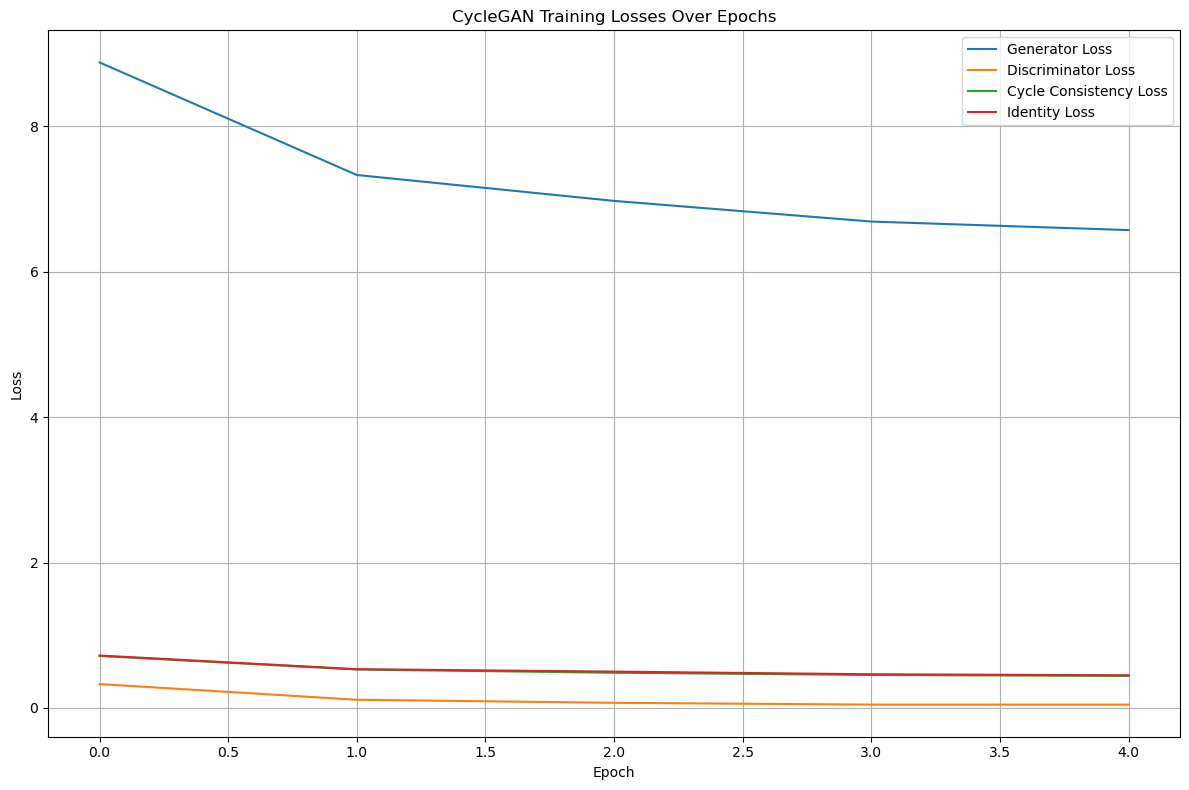

In [64]:
cyclegan.plot_training_losses()

In [ ]:
cyclegan.gen_AB.save("saved_models/gen_RockToClassical") 
cyclegan.gen_BA.save("saved_models/gen_ClassicalToRock")
cyclegan.disc_A.save("saved_models/disc_Rock")
cyclegan.disc_B.save("saved_models/disc_Classical")

In [65]:
test_A=datasets["test_A"]
x= next(iter(test_A.take(1)))

In [83]:
x_tradotto=cyclegan.gen_AB(x)


In [84]:

x_tradotto=x_tradotto.numpy()
x_tradotto=x_tradotto.squeeze()
x_tradotto.shape

(128, 512)

In [85]:
reconstructor.reconstruct_and_show(
    input_spectrogram=x_tradotto,
    genre_name=target_genre,
    output_path=output_wav_path
)

Step 1: Denormalizing spectrogram...
Step 2: Un-resizing spectrogram...
Step 3: Reversing log scaling...
Step 4: Inverting mel spectrogram to audio (Griffin-Lim)...


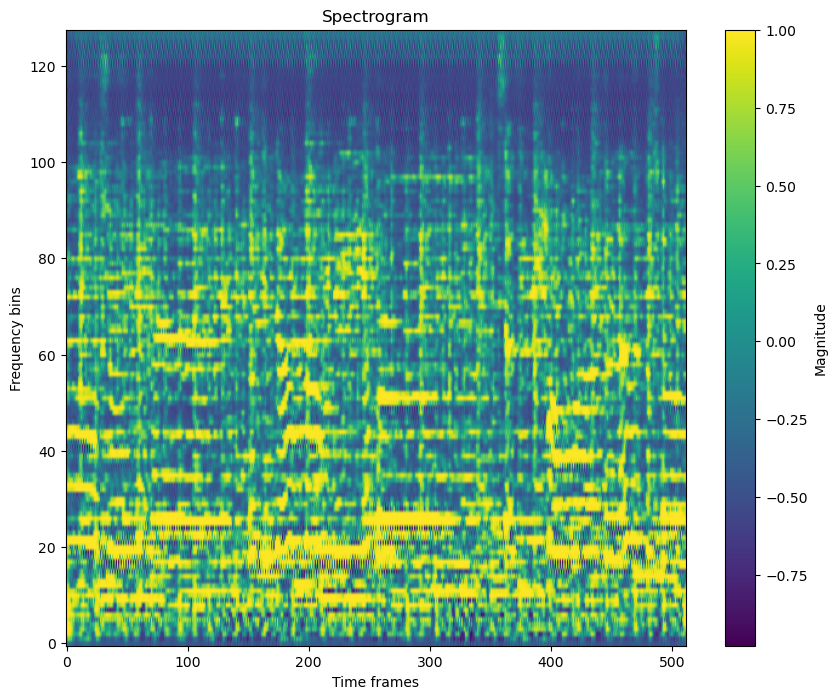

In [67]:
# Assuming your spectrogram is a TensorFlow tensor
spectrogram_array = x_tradotto.numpy()  # Convert to numpy if it's a tensor
spectrogram_2d = spectrogram_array[0, :, :, 0]  # Remove batch and channel dimensions

plt.figure(figsize=(10, 8))
plt.imshow(spectrogram_2d, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Time frames')
plt.ylabel('Frequency bins')
plt.title('Spectrogram')
plt.show()

In [ ]:
import librosa
import soundfile as sf
from IPython.display import Audio, display
# Basic reconstruction
spec_2d_original = x.numpy()[0, :, :, 0]
spec_2d_transformed = x_tradotto.numpy()[0, :, :, 0]

# If it's a log mel spectrogram, convert back from log scale
if spec_2d_original.min() < 0:  # Likely log scale
    mel_spec_original = np.exp(spec_2d_original)  # or 10**(spec_2d/10) for dB scale
    mel_spec_transformed = np.exp(spec_2d_transformed) 
else:
    mel_spec_original = spec_2d_original
    mel_spec_transformed=spec_2d_transformed

# Convert mel spectrogram back to linear spectrogram
linear_spec_original = librosa.feature.inverse.mel_to_stft(
    mel_spec_original, 
    sr=22050,  # Sample rate used during training
    n_fft=2048,  # FFT size used during training
    fmin=0,
    fmax=8000
)

linear_spec_transformed = librosa.feature.inverse.mel_to_stft(
    mel_spec_transformed, 
    sr=22050,  # Sample rate used during training
    n_fft=2048,  # FFT size used during training
    fmin=0,
    fmax=8000
)

# Convert spectrogram to audio using Griffin-Lim algorithm
audio_original = librosa.griffinlim(linear_spec_original, n_iter=60, hop_length=512)
audio_transformed = librosa.griffinlim(linear_spec_transformed, n_iter=60, hop_length=512)



# Play in notebook

display(Audio(audio_original, rate=22050))
display(Audio(audio_transformed, rate=22050))

In [ ]:
gen_g.summary()

In [ ]:
disc_x.summary()

In [ ]:
#######VECCHIA VERSIONE IGNORA
# Create the models
gen_g = generator_with_dilated_cnn(input_shape=IMG_SHAPE, name="G_Rock_to_Classical")
gen_f = generator_with_dilated_cnn(input_shape=IMG_SHAPE, name="F_Classical_to_Rock")
disc_x = discriminator(input_shape=IMG_SHAPE, name="D_Rock")
disc_y = discriminator(input_shape=IMG_SHAPE, name="D_Classical")

# Define loss functions for GANs (using hinge loss is often more stable)
def generator_loss(generated):
    return -tf.reduce_mean(generated)

def discriminator_loss(real, generated):
    real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real))
    generated_loss = tf.reduce_mean(tf.nn.relu(1.0 + generated))
    return (real_loss + generated_loss) * 0.5

# Create and compile the CycleGAN model
cycle_gan_model = CycleGan(gen_g, gen_f, disc_x, disc_y)
cycle_gan_model.compile(
    gen_g_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_f_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_x_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss
)

# Train the model
cycle_gan_model.fit(
    train_ds,
    epochs=50 # Adjust as needed
)